In [77]:
# Import required libraries
import torch
import torchvision
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from albumentations.pytorch import ToTensorV2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import glob
import timm
import uuid
import tqdm
from PIL import Image
import cv2

In [78]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [79]:
wandb.login()

True

In [80]:
config = {
    "image_size": (224,224),
    "batch_size": 16,
    "base_model": "swin_s3_tiny_224"
}

In [81]:
# Get data
# Split data into train and test
categories = {
    "sub": 0,
    "no_sub": 1,
}

dataset_path = "/notebooks/gsoc-prep-23/ml4sci/data/lenses/"

# Get file paths as a list
all_files = glob.glob(dataset_path + "*/*")
all_labels = [x.split('/')[-2] for x in all_files]

print("Got files", len(all_files))

Got files 10000


In [82]:
print(all_files[0], all_labels[0])
print(all_files[-1], all_labels[-1])

/notebooks/gsoc-prep-23/ml4sci/data/lenses/sub/image_135943293325140772155714425003138958756.jpg sub
/notebooks/gsoc-prep-23/ml4sci/data/lenses/no_sub/image_30922263493132764425775209234469258991.jpg no_sub


(150, 150)


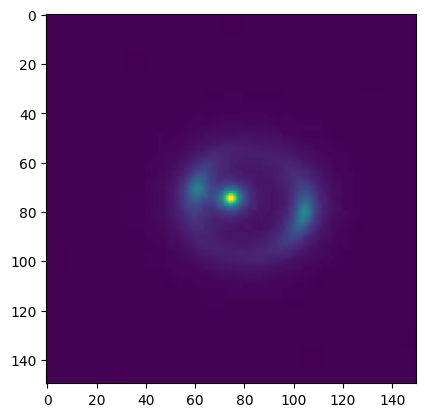

In [83]:
test = Image.open(all_files[0])
print(test.size)
plt.imshow(test)

In [86]:
# Define pytorch model
# Use timm for pretrained models
# Define the pytorch model
# Create a model using timm
def create_model(model_name,num_classes):
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes, in_chans=1)
    # Check if classifier is parameter of the model
    if hasattr(model, 'head'):
        model.head = torch.nn.Sequential(
            torch.nn.Linear(model.head.in_features, 512),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Linear(512, num_classes),
            torch.nn.Sigmoid(),
        )
    return model

In [87]:
# Dataset object
# Use albumentations for data augmentation
class SubstructureBinaryDataset(torch.utils.data.Dataset):
    def __init__(self, data_files, transform=None):
        self.data_files = data_files
        self.transform = transform
    def __len__(self):
        return len(self.data_files)
    def __getitem__(self, idx):
        image = np.array((Image.open(self.data_files[idx])).convert('L'))
        label = categories[self.data_files[idx].split("/")[-2]]
        # print(image.shape)
        if self.transform:
            image = self.transform(image=image)["image"]
        label = torch.tensor([label], dtype=torch.float32)
        # Min max normalise
        image = (image - image.min() ) / ( image.max() - image.min())
        # print(image)
        return image.to(torch.float32),label

In [88]:
# Split into 90-10
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(all_files, test_size=0.1, random_state=42, stratify=all_labels)

In [89]:
# Define dataloaders

train_transform = A.Compose([
    A.Resize(*config['image_size']),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.pytorch.transforms.ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(*config['image_size']),
    A.pytorch.transforms.ToTensorV2()
])

train_dataset = SubstructureBinaryDataset(train_files, transform=train_transform)
val_dataset = SubstructureBinaryDataset(val_files, transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=1)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)

In [90]:
b = next(iter(train_dataloader))
print(b[0][0].shape)
print(b[1][0].shape)

torch.Size([1, 224, 224])
torch.Size([1])


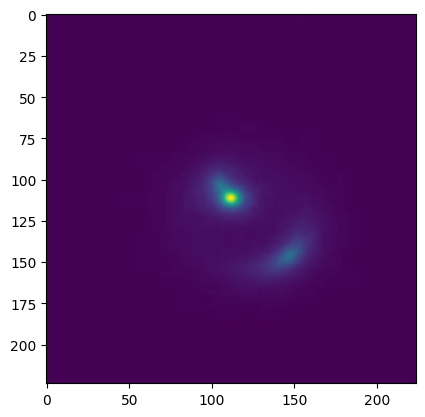

In [91]:
plt.imshow(np.transpose(b[0][0].cpu().numpy(), (1,2,0)))

In [92]:
b[0][0]

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]]])

## Pytorch Lightning

In [40]:
# Define pl module
class SubstructureModel(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-3):
        super().__init__()
        self.model = create_model(config['base_model'], num_classes=num_classes)
        self.criterion = torch.nn.BCELoss()
        self.lr = lr
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [41]:
# Train model
model = SubstructureModel(1)

In [42]:
# Sanity check model
y = model(torch.rand((2,1,224,224)))
print(y.shape)

torch.Size([2, 1])


In [43]:
run_id = "ml4sci:t5:"+config['base_model']+":"+str(uuid.uuid4().hex)[:3]

wandb_logger = WandbLogger(
    project="gsoc-ml4sci",
    entity="lawjarp",
    name=run_id,
    group=config['base_model'],
    log_model=True,
)
# Initialize a trainer
trainer = pl.Trainer(
    # precision='16-mixed'
    max_epochs=25,
    callbacks=[
        RichProgressBar(leave=True),
        ModelCheckpoint(dirpath='./models/', filename=run_id, monitor="val_loss", mode="min")
    ],
    logger=wandb_logger
)

wandb: Currently logged in as: lawjarp. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [44]:
trainer.fit(model, train_dataloader, val_dataloader)

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /notebooks/gsoc-prep-23/ml4sci/notebooks/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
model.to('cpu')
model.eval()
model_outputs = []
true_labels = []
with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to('cpu'), labels.to('cpu')
        outputs = model(inputs)
        model_outputs.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def compute_auc_roc(model_outputs, true_labels):
    fpr, tpr, _ = roc_curve(true_labels, model_outputs)
    roc_auc = roc_auc_score(true_labels, model_outputs)
    return roc_auc, fpr, tpr

auc, fpr, tpr = compute_auc_roc(model_outputs, true_labels)

In [ ]:
print(auc)

In [ ]:
wandb.finish()

## MISC

In [93]:
from fastai.vision.all import *

In [94]:
dls = DataLoaders(train_dataloader, val_dataloader)

In [95]:
model = create_model(config['base_model'], 1)

In [96]:
learn = Learner(dls, model, loss_func=BCELossFlat(), metrics=accuracy)

In [97]:
learn.lr_find()

RuntimeError: Exception occured in `TrainEvalCallback` when calling event `before_fit`:
	CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [60]:
learn.fit_one_cycle(25, 0.006)

epoch,train_loss,valid_loss,accuracy,time
0,0.707665,0.693560,0.500000,02:30
1,0.701163,0.693330,0.500000,01:57


KeyboardInterrupt: 